# Otimização de Arquitetura de Redes Neurais com Algoritmos Genéticos 

## Teste 01: Dataset MNIST

### 01. Importação de Bibliotecas

In [1]:
# Importação de Bibliotecas
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 02. Separação do Dataset

In [2]:
# Preparando os datasets e dataloaders
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Dividindo o trainset em treino e validação
val_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size
trainset, validset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

### 03. Arquitetura inicial da Rede Neural

In [3]:
# Definindo a arquitetura da rede neural
class SimpleNet(nn.Module):
    def __init__(self, n_neurons, activation_fn):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, n_neurons)
        self.activation = activation_fn
        self.fc2 = nn.Linear(n_neurons, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

### 04. Função de treinamento e avaliação do Modelo

In [4]:
# Função de treinamento e avaliação
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Treinamento', unit='época'):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc='Batchs', leave=False, unit='batch'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Época {epoch + 1}, Loss: {avg_loss:.4f}")
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Avaliação', unit='batch'):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start_time
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, train_losses, time_taken, cm

### 05. Algoritmo Genético

In [5]:
# Função de avaliação do indivíduo
def evaluate_individual(individual):
    n_neurons, activation_idx, learning_rate, batch_size = individual

    # Certifique-se de que activation_idx esteja dentro do intervalo esperado
    activation_idx = min(max(activation_idx, 0), 1)
    activation_fn = [nn.ReLU(), nn.Sigmoid()][activation_idx]
    
    model = SimpleNet(n_neurons, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Treinamento no conjunto de treinamento
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for epoch in range(3):  # Treinando por 3 épocas como exemplo
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Avaliação no conjunto de validação
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy,

In [6]:
# Configuração do Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 200)  # Número de neurônios
toolbox.register("attr_activation", random.randint, 0, 1)  # Função de ativação (ReLU ou Sigmoid)
toolbox.register("attr_float", random.uniform, 0.001, 0.1)  # Taxa de aprendizado
toolbox.register("attr_batch", random.randint, 32, 128)  # Tamanho do batch

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_int, toolbox.attr_activation, toolbox.attr_float, toolbox.attr_batch), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=200, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Genético
population = toolbox.population(n=10)
NGEN = 5
for gen in tqdm(range(NGEN), desc='Gerações'):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    
    fits = list(tqdm(map(toolbox.evaluate, offspring), total=len(offspring), desc="Avaliando Indivíduos"))
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Seleciona o melhor indivíduo
top_ind = tools.selBest(population, k=1)[0]

# Parâmetros do melhor indivíduo
best_params = {
    'n_neurons': top_ind[0],
    'activation_idx': top_ind[1],
    'learning_rate': top_ind[2],
    'batch_size': top_ind[3]
}

Gerações: 100%|██████████████████████████████████████████████████████████████████████████| 5/5 [36:09<00:00, 433.91s/it]


In [7]:
print("Melhor indivíduo:", top_ind)
print("Parâmetros:", best_params)

Melhor indivíduo: [86, 0, 0.09616977616285315, 53]
Parâmetros: {'n_neurons': 86, 'activation_idx': 0, 'learning_rate': 0.09616977616285315, 'batch_size': 53}


### 06. Treinamento dos Modelos

#### Modelo Não Otimizado 1

In [12]:
# Modelo Não Otimizado 1
model_non_opt_1 = SimpleNet(n_neurons=50, activation_fn=nn.Sigmoid())
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_non_opt_1.parameters(), lr=0.01)

accuracy_non_opt_1, train_losses_non_opt_1, time_non_opt_1, cm_non_opt_1 = train_and_evaluate(model_non_opt_1, trainloader, testloader, criterion_1, optimizer_1)

Treinamento:  10%|██████▊                                                             | 1/10 [00:18<02:43, 18.11s/época]

Época 1, Loss: 1.8925



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:33<02:12, 16.57s/época]

Época 2, Loss: 1.1276



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:49<01:53, 16.27s/época]

Época 3, Loss: 0.7676



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:05<01:36, 16.02s/época]

Época 4, Loss: 0.6048



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:20<01:19, 15.88s/época]

Época 5, Loss: 0.5164



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:36<01:03, 15.81s/época]

Época 6, Loss: 0.4616



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:52<00:47, 15.79s/época]

Época 7, Loss: 0.4244



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:07<00:31, 15.75s/época]

Época 8, Loss: 0.3974



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:23<00:15, 15.73s/época]

Época 9, Loss: 0.3766



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:39<00:00, 15.91s/época]


Época 10, Loss: 0.3601


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 42.60batch/s]


#### Modelo Não Otimizado 2

In [13]:
# Modelo Não Otimizado 2
model_non_opt_2 = SimpleNet(n_neurons=20, activation_fn=nn.ReLU())
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_non_opt_2.parameters(), lr=0.05)

accuracy_non_opt_2, train_losses_non_opt_2, time_non_opt_2, cm_non_opt_2 = train_and_evaluate(model_non_opt_2, trainloader, testloader, criterion_2, optimizer_2)

Treinamento:  10%|██████▊                                                             | 1/10 [00:18<02:42, 18.08s/época]

Época 1, Loss: 0.4899



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:34<02:15, 16.99s/época]

Época 2, Loss: 0.2959



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:49<01:53, 16.28s/época]

Época 3, Loss: 0.2529



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:05<01:35, 15.97s/época]

Época 4, Loss: 0.2241



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:20<01:18, 15.74s/época]

Época 5, Loss: 0.2040



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:36<01:02, 15.69s/época]

Época 6, Loss: 0.1882



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:51<00:46, 15.60s/época]

Época 7, Loss: 0.1751



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:06<00:31, 15.52s/época]

Época 8, Loss: 0.1657



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:22<00:15, 15.54s/época]

Época 9, Loss: 0.1572



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.82s/época]


Época 10, Loss: 0.1491


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.44batch/s]


#### Modelo Não Otimizado 3

In [15]:
# Modelo Não Otimizado 3
model_non_opt_3 = SimpleNet(n_neurons=150, activation_fn=nn.Sigmoid())
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_non_opt_3.parameters(), lr=0.07)

accuracy_non_opt_3, train_losses_non_opt_3, time_non_opt_3, cm_non_opt_3 = train_and_evaluate(model_non_opt_3, trainloader, testloader, criterion_2, optimizer_3)

Treinamento:  10%|██████▊                                                             | 1/10 [00:17<02:39, 17.74s/época]

Época 1, Loss: 0.7580



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:34<02:17, 17.17s/época]

Época 2, Loss: 0.3466



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:51<01:59, 17.07s/época]

Época 3, Loss: 0.2985



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:07<01:40, 16.69s/época]

Época 4, Loss: 0.2672



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:23<01:22, 16.51s/época]

Época 5, Loss: 0.2423



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:39<01:05, 16.36s/época]

Época 6, Loss: 0.2225



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:55<00:48, 16.27s/época]

Época 7, Loss: 0.2047



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:12<00:32, 16.29s/época]

Época 8, Loss: 0.1899



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:29<00:16, 16.44s/época]

Época 9, Loss: 0.1771



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.59s/época]


Época 10, Loss: 0.1655


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 38.48batch/s]


#### Modelo Otimizado

In [16]:
# Modelo Otimizado
activation_fn = [nn.ReLU(), nn.Sigmoid()][best_params['activation_idx']]
model_opt = SimpleNet(best_params['n_neurons'], activation_fn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_opt.parameters(), lr=best_params['learning_rate'])

accuracy_opt, train_losses_opt, time_opt, cm_opt = train_and_evaluate(model_opt, trainloader, testloader, criterion, optimizer)

Treinamento:  10%|██████▊                                                             | 1/10 [00:18<02:47, 18.56s/época]

Época 1, Loss: 0.4214



Treinamento:  20%|█████████████▌                                                      | 2/10 [00:35<02:22, 17.76s/época]

Época 2, Loss: 0.1906



Treinamento:  30%|████████████████████▍                                               | 3/10 [00:51<01:57, 16.80s/época]

Época 3, Loss: 0.1406



Treinamento:  40%|███████████████████████████▏                                        | 4/10 [01:07<01:38, 16.38s/época]

Época 4, Loss: 0.1154



Treinamento:  50%|██████████████████████████████████                                  | 5/10 [01:22<01:20, 16.15s/época]

Época 5, Loss: 0.0985



Treinamento:  60%|████████████████████████████████████████▊                           | 6/10 [01:38<01:04, 16.08s/época]

Época 6, Loss: 0.0862



Treinamento:  70%|███████████████████████████████████████████████▌                    | 7/10 [01:54<00:48, 16.03s/época]

Época 7, Loss: 0.0772



Treinamento:  80%|██████████████████████████████████████████████████████▍             | 8/10 [02:10<00:31, 15.94s/época]

Época 8, Loss: 0.0715



Treinamento:  90%|█████████████████████████████████████████████████████████████▏      | 9/10 [02:26<00:15, 15.91s/época]

Época 9, Loss: 0.0642



Treinamento: 100%|███████████████████████████████████████████████████████████████████| 10/10 [02:42<00:00, 16.23s/época]


Época 10, Loss: 0.0584


Avaliação: 100%|███████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.38batch/s]


### 07. Avaliação dos Modelos

In [17]:
# Comparação dos Resultados
print(f"Modelo Não Otimizado 1: Acurácia = {accuracy_non_opt_1:.4f}, Loss = {train_losses_non_opt_1[-1]:.4f}, Tempo = {time_non_opt_1:.2f}s")
print(f"Modelo Não Otimizado 2: Acurácia = {accuracy_non_opt_2:.4f}, Loss = {train_losses_non_opt_2[-1]:.4f}, Tempo = {time_non_opt_2:.2f}s")
print(f"Modelo Não Otimizado 3: Acurácia = {accuracy_non_opt_3:.4f}, Loss = {train_losses_non_opt_3[-1]:.4f}, Tempo = {time_non_opt_3:.2f}s")
print(f"Modelo Otimizado: Acurácia = {accuracy_opt:.4f}, Loss = {train_losses_opt[-1]:.4f}, Tempo = {time_opt:.2f}s")

Modelo Não Otimizado 1: Acurácia = 0.9087, Loss = 0.3601, Tempo = 161.49s
Modelo Não Otimizado 2: Acurácia = 0.9484, Loss = 0.1491, Tempo = 160.61s
Modelo Não Otimizado 3: Acurácia = 0.9519, Loss = 0.1655, Tempo = 168.47s
Modelo Otimizado: Acurácia = 0.9725, Loss = 0.0584, Tempo = 164.74s


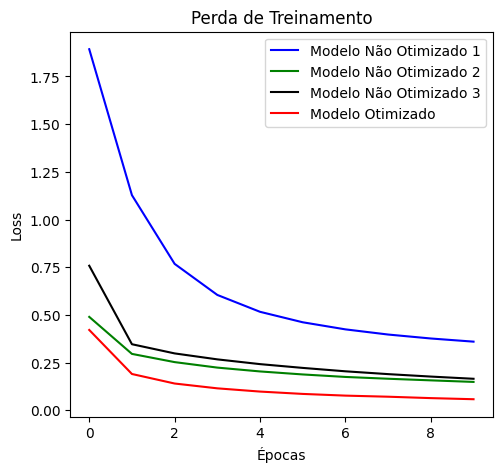

In [18]:
# Plotando gráficos comparativos
plt.figure(figsize=(12, 5))

# Gráfico da perda de treinamento
plt.subplot(1, 2, 1)
plt.plot(train_losses_non_opt_1, label='Modelo Não Otimizado 1', color='blue')
plt.plot(train_losses_non_opt_2, label='Modelo Não Otimizado 2', color='green')
plt.plot(train_losses_non_opt_3, label='Modelo Não Otimizado 3', color='black')
plt.plot(train_losses_opt, label='Modelo Otimizado', color='red')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Perda de Treinamento')
plt.legend()

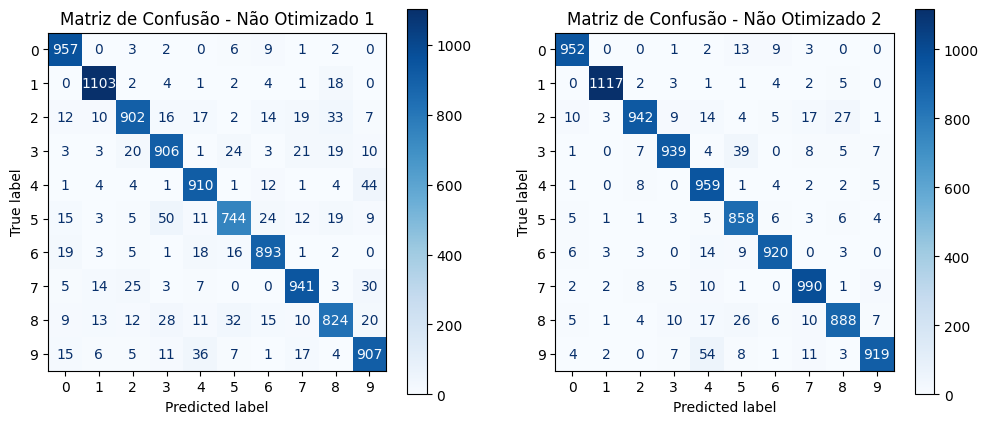

In [27]:
# Plotando a Matriz de Confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 1
disp_non_opt_1 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_1, display_labels=range(10))
disp_non_opt_1.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Matriz de Confusão - Não Otimizado 1')

# Matriz de Confusão - Modelo Não Otimizado 2
disp_non_opt_2 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_2, display_labels=range(10))
disp_non_opt_2.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Matriz de Confusão - Não Otimizado 2')

plt.show()

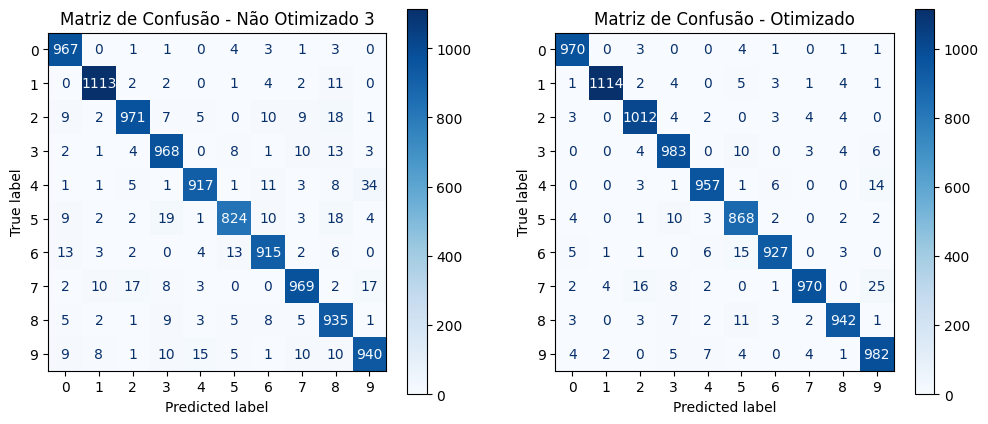

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 3
disp_non_opt_3 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_3, display_labels=range(10))
disp_non_opt_3.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Matriz de Confusão - Não Otimizado 3')

# Matriz de Confusão - Modelo Otimizado
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=range(10))
disp_opt.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Matriz de Confusão - Otimizado')

plt.show()